In [1]:
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from nltk.stem import LancasterStemmer
import nltk
import numpy as np
import random
import pickle
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize

nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
with open('Dataset.json', 'r') as file:
    data = json.load(file)


In [4]:
stemmer = LancasterStemmer()

def tokenize_and_stem(word):
    return stemmer.stem(word.lower())

def create_bow_patterns(patterns, all_words):
    bag_of_words = [0 for _ in range(len(all_words))]
    for pattern in patterns:
        for word in word_tokenize(pattern):
            stemmed_word = tokenize_and_stem(word)
            if stemmed_word in all_words:
                bag_of_words[all_words.index(stemmed_word)] = 1
    return np.array(bag_of_words)


In [5]:
all_words = []
classes = []
data_points = []

for intent in data['book']:
    for pattern in intent['patterns']:
        word_list = word_tokenize(pattern)
        all_words.extend([tokenize_and_stem(w) for w in word_list])
        data_points.append((word_list, intent['tag']))

    if intent['tag'] not in classes:
        classes.append(intent['tag'])

all_words = sorted(set(all_words))
classes = sorted(classes)

training_data = []
output_data = []

for (pattern, tag) in data_points:
    bag_of_words = create_bow_patterns(pattern, all_words)
    output_row = [0 for _ in range(len(classes))]
    output_row[classes.index(tag)] = 1
    training_data.append(bag_of_words)
    output_data.append(output_row)

training_data = np.array(training_data)
output_data = np.array(output_data)


In [6]:
class ChatDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

train_dataset = ChatDataset(training_data, output_data)
train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True)


In [8]:
class ChatModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super(ChatModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return self.softmax(self.fc4(x))

input_size = len(training_data[0])
hidden_size1 = 64
hidden_size2 = 32
hidden_size3 = 16
output_size = len(classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ChatModel(input_size, hidden_size1, hidden_size2, hidden_size3, output_size).to(device)


In [9]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 700
losses = []
for epoch in range(num_epochs):
    epoch_loss = 0
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(train_loader)
    losses.append(avg_epoch_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}')

Epoch [1/700], Loss: 0.0817
Epoch [2/700], Loss: 0.0814
Epoch [3/700], Loss: 0.0807
Epoch [4/700], Loss: 0.0782
Epoch [5/700], Loss: 0.0724
Epoch [6/700], Loss: 0.0640
Epoch [7/700], Loss: 0.0551
Epoch [8/700], Loss: 0.0477
Epoch [9/700], Loss: 0.0395
Epoch [10/700], Loss: 0.0332
Epoch [11/700], Loss: 0.0284
Epoch [12/700], Loss: 0.0237
Epoch [13/700], Loss: 0.0202
Epoch [14/700], Loss: 0.0173
Epoch [15/700], Loss: 0.0152
Epoch [16/700], Loss: 0.0135
Epoch [17/700], Loss: 0.0126
Epoch [18/700], Loss: 0.0114
Epoch [19/700], Loss: 0.0098
Epoch [20/700], Loss: 0.0088
Epoch [21/700], Loss: 0.0071
Epoch [22/700], Loss: 0.0072
Epoch [23/700], Loss: 0.0069
Epoch [24/700], Loss: 0.0065
Epoch [25/700], Loss: 0.0058
Epoch [26/700], Loss: 0.0056
Epoch [27/700], Loss: 0.0054
Epoch [28/700], Loss: 0.0050
Epoch [29/700], Loss: 0.0045
Epoch [30/700], Loss: 0.0043
Epoch [31/700], Loss: 0.0044
Epoch [32/700], Loss: 0.0066
Epoch [33/700], Loss: 0.0035
Epoch [34/700], Loss: 0.0036
Epoch [35/700], Loss: 0

In [ ]:
torch.save(model.state_dict(), 'chat_model.pth')

with open('all_words.pkl', 'wb') as f:
    pickle.dump(all_words, f)
with open('classes.pkl', 'wb') as f:
    pickle.dump(classes, f)


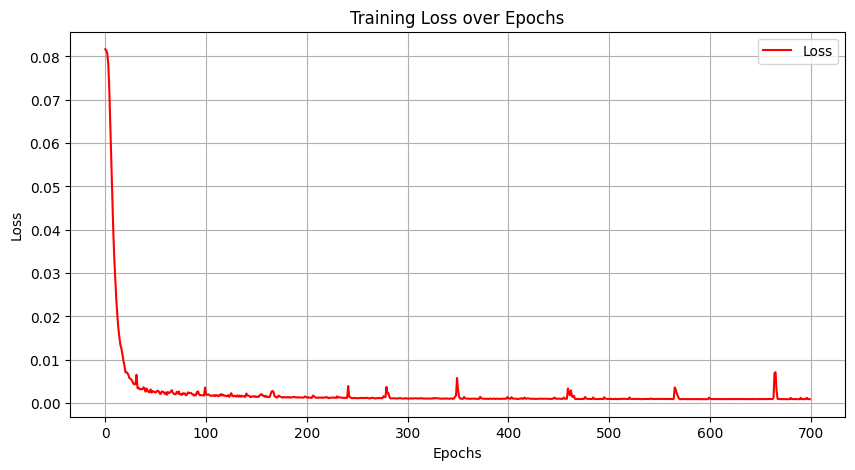

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Loss', color='red')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


In [11]:
def chat():
    print('Start talking with the bot (type quit to stop)!')
    while True:
        inp = input('You: ')
        if inp.lower() == 'quit':
            break

        # Convert input to bag of words
        bag = create_bow_patterns([inp], all_words)
        bag_tensor = torch.tensor(bag, dtype=torch.float32).unsqueeze(0).to(device)  # Move input to GPU

        # Get model predictions
        with torch.no_grad():
            model.eval()
            results = model(bag_tensor)
        results_index = torch.argmax(results).item()
        tag = classes[results_index]

        # Find response for the tag
        for tg in data['book']:
            if tg['tag'] == tag:
                responses = tg['responses']
        print('Bot: ' + random.choice(responses))

chat()

Start talking with the bot (type quit to stop)!
You: Tell me about the novel
Bot: The key figures in the story are: Elesin, Olunde, Iyaloja, Pilkings, and various members of the community who contribute to the narrative and themes of duty, tradition, and cultural conflict.
You: tell me about the novel
Bot: The main characters in 'Death and the King's Horseman' include: Elesin, the King’s Horseman; Olunde, his son; Iyaloja, the Mother of the Market; Pilkings, the British colonial officer; and the community members who play a vital role in supporting and reflecting the traditions of the Yoruba culture.
You: tell me about the novel
Bot: The main characters in 'Death and the King's Horseman' include: Elesin, the King’s Horseman; Olunde, his son; Iyaloja, the Mother of the Market; Pilkings, the British colonial officer; and the community members who play a vital role in supporting and reflecting the traditions of the Yoruba culture.
You: Summarize the novel
Bot: The plot revolves around the

KeyboardInterrupt: Interrupted by user